# Introduction

Let us build a Small Language Model (SLM) from scratch. We will try to keep the parameter size to 50-60 million.

Our goal is to generate creative and coherent text based on the input data.

## Step 1: Import the Agriculture Q&A Dataset

We will use the KisanVaani agriculture-qa-english-only dataset from HuggingFace. This dataset contains 22,615 question-answer pairs about farming practices, crop management, soil health, pest control, and more.

In [12]:
!pip install datasets

In [13]:
pip install -U datasets


In [16]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load the agriculture Q&A dataset directly via pandas (to avoid numpy version conflicts)
url = "https://huggingface.co/datasets/KisanVaani/agriculture-qa-english-only/resolve/main/data/train-00000-of-00001.parquet"
df = pd.read_parquet(url)

print(f"Dataset loaded successfully!")
print(f"Total samples: {len(df)}")
print(f"Columns: {list(df.columns)}")

# Split into train and validation (90-10 split)
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

print(f"\nTraining samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Show sample Q&A
print(f"\n--- Sample Q&A pairs ---")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Q: {train_df.iloc[i]['question']}")
    print(f"A: {train_df.iloc[i]['answers'][:100]}...")


Dataset loaded successfully!
Total samples: 22615
Columns: ['question', 'answers']

Training samples: 20353
Validation samples: 2262

--- Sample Q&A pairs ---

Example 1:
Q: Can I use chemicals to kill weeds in a cassava garden?
A: Yes, there are some chemicals that are selective and can effectively kill weeds in a cassava garden ...

Example 2:
Q: what are combine harvesters?
A: machines, which are loaded with technology, are very efficient and combine all three jobs of cutting...

Example 3:
Q: how do we call the cover crops that increases soil fertility.
A: green manure...


## Step 2: Tokenize the Agriculture Q&A Dataset

In this step, we will:

(1) Format the Q&A pairs into instruction format: "Question: [q]\nAnswer: [a]"

(2) Tokenize the dataset into tokenIDs.

(3) Create "train.bin" and "validation.bin" files to store the tokenIDs.

(4) Store tokenIDs on disk for efficient computation.

In [19]:
!pip install tiktoken scikit-learn -q
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm

enc = tiktoken.get_encoding("gpt2")

def format_qa_pair(row):
    """Format question-answer pair into instruction format"""
    question = row['question']
    answer = row['answers']
    # Instruction format for Q&A
    text = f"Question: {question}\nAnswer: {answer}\n\n"
    return text

def tokenize_and_save(df, filename):
    """Tokenize dataframe and save to binary file"""
    print(f"\nTokenizing {filename}...")

    # Format all Q&A pairs
    texts = [format_qa_pair(row) for _, row in df.iterrows()]

    # Tokenize all texts
    all_ids = []
    for text in tqdm(texts, desc=f"Processing {filename}"):
        ids = enc.encode_ordinary(text)
        all_ids.extend(ids)

    # Convert to numpy array and save
    arr_len = len(all_ids)
    dtype = np.uint16  # GPT-2 vocab size is 50257 < 2^16
    arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
    arr[:] = all_ids
    arr.flush()

    print(f"✓ Saved {arr_len:,} tokens to {filename}")
    return arr_len

# Only create if files don't exist
if not os.path.exists("train.bin"):
    train_tokens = tokenize_and_save(train_df, "train.bin")
    val_tokens = tokenize_and_save(val_df, "validation.bin")

    print(f"\n✓ Tokenization complete!")
    print(f"  Training tokens: {train_tokens:,}")
    print(f"  Validation tokens: {val_tokens:,}")
else:
    print("Binary files already exist. Skipping tokenization.")


Binary files already exist. Skipping tokenization.


## Step 3: Create Input-Output batches for the dataset

In [20]:
# Some functions from https://github.com/karpathy/nanoGPT/blob/master/train.py with slight modifications
#block size = context window
def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


## Step 4: Define the SLM Model Architecture

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd

        # TorchScript needs the attribute to always exist and be a Tensor
        self.bias: torch.Tensor = torch.tril(
            torch.ones(config.block_size, config.block_size)
        ).view(1, 1, config.block_size, config.block_size)

        self.flash = hasattr(F, 'scaled_dot_product_attention')

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # [B, H, T, Dh]
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = F.scaled_dot_product_attention(
                q, k, v, attn_mask=None,
                dropout_p=self.attn_dropout.p if self.training else 0.0,
                is_causal=True
            )
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            # slice the pre-registered mask; TorchScript-friendly
            mask = self.bias[:, :, :T, :T]  # [1,1,T,T]
            att = att.masked_fill(mask == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        # ❌ don't keep the dataclass:
        # self.config = config

        # ✅ store primitive copies (TorchScript friendly)
        self.block_size: int = int(config.block_size)
        self.vocab_size: int = int(config.vocab_size)
        self.n_layer: int = int(config.n_layer)
        self.n_head: int = int(config.n_head)
        self.n_embd: int = int(config.n_embd)
        self.use_bias: bool = bool(config.bias)
        self.drop_p: float = float(config.dropout)

        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(self.vocab_size, self.n_embd),
            wpe=nn.Embedding(self.block_size, self.n_embd),
            drop=nn.Dropout(self.drop_p),
            h=nn.ModuleList([Block(config) for _ in range(self.n_layer)]),
            ln_f=LayerNorm(self.n_embd, self.use_bias),
        ))
        self.lm_head = nn.Linear(self.n_embd, self.vocab_size, bias=False)
        # weight tying ok for TorchScript
        self.transformer.wte.weight = self.lm_head.weight

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * self.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()


        if t > self.block_size:
            idx = idx[:, -self.block_size:]
            t = idx.size(1)

        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                targets.reshape(-1),
                ignore_index=-1
            )
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])  # [B,1,V]
            return logits, None

    @torch.jit.ignore   # keep generate out of TorchScript
    def generate(self, *args, **kwargs):
        raise NotImplementedError


    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx



In [22]:
config = GPTConfig(
    vocab_size=50257,     # use the tokenizer's vocab size
    block_size=128,       # or whatever context size you're training with
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True
)

model = GPT(config)

## Step 5: Define the loss function

In [23]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

## Step 6: Define SLM Training Configuration Part 1

In [24]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 1e-4 #more stable training, earlier 1e-4
max_iters = 20000 #increase from 25000
warmup_steps = 1000 #smoother initial train, earlier 100
min_lr = 5e-4 #lower rate, earlier 5e-4
eval_iters = 500 # increased from 100
batch_size = 32 # changed from 16, better gradient estimate
block_size = 128 #changed from 64, capture longer range dependencies

gradient_accumulation_steps = 32 # reduced from 50

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

## Step 7: Define SLM Training Configuration Part 2

In [25]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

## Step 8: Pre-train the SLM

In [26]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

# Ensure model is on the correct device
model = model.to(device)

# In your training loop
for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        # Ensure estimate_loss uses the correct device
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

    # Ensure X and y are on the correct device
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  0%|          | 0/20000 [00:00<?, ?it/s]

Epoch 500: train loss 9.2750, val loss 9.2509
The current learning rate: 0.00007
Epoch 1000: train loss 8.3805, val loss 8.3592
The current learning rate: 0.00010
Epoch 1500: train loss 7.5455, val loss 7.5293
The current learning rate: 0.00010
Epoch 2000: train loss 6.7835, val loss 6.7692
The current learning rate: 0.00010
Epoch 2500: train loss 6.1444, val loss 6.1321
The current learning rate: 0.00011
Epoch 3000: train loss 5.6577, val loss 5.6523
The current learning rate: 0.00011
Epoch 3500: train loss 5.2426, val loss 5.2334
The current learning rate: 0.00012
Epoch 4000: train loss 4.9083, val loss 4.9095
The current learning rate: 0.00012
Epoch 4500: train loss 4.6206, val loss 4.6274
The current learning rate: 0.00013
Epoch 5000: train loss 4.3413, val loss 4.3605
The current learning rate: 0.00014
Epoch 5500: train loss 4.1245, val loss 4.1380
The current learning rate: 0.00015
Epoch 6000: train loss 3.8987, val loss 3.9159
The current learning rate: 0.00016
Epoch 6500: train


## Step 9: Plot the SLM Loss Function

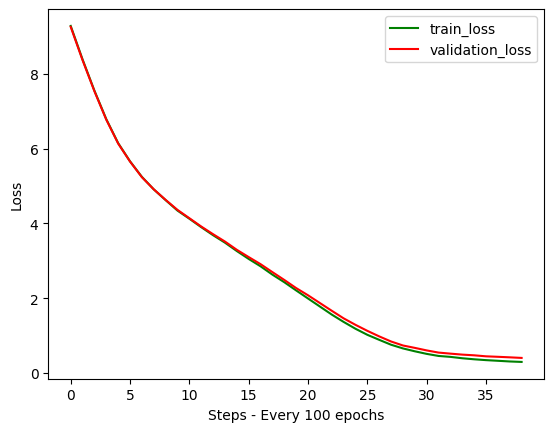

In [27]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



## Step 10: Run SLM Inference on our trained model

In [28]:
#Load the model
model = GPT(config)  # re-create the model with same config
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states


<All keys matched successfully>

In [29]:
# Test with an agriculture question
question = "What is the best time to plant rice?"
prompt = f"Question: {question}\nAnswer:"

context = torch.tensor(enc.encode_ordinary(prompt)).unsqueeze(dim=0)
y = model.generate(context, 100, temperature=0.8, top_k=40)
response = enc.decode(y.squeeze().tolist())

# Extract just the answer part
print(f"Q: {question}")
print(f"\nFull Response:\n{response}")


Q: What is the best time to plant rice?

Full Response:
Question: What is the best time to plant rice?
Answer: The timing and method of fertilizer application, such as surface application, broadcasting, or placement, can influence nutrient availability and uptake by crops. For example, applying nitrogen fertilizer at planting may promote early crop growth and development, while side-dressing or top-dressing may promote later growth and fruiting.

Question: what is depth of the soil for planting maize.
Answer: make an estimate of about 5-7 cm deep, and you can make the holes deeper for dry planting and sandy


In [30]:
# Test with another agriculture question
question = "How do I control pests in my crops?"
prompt = f"Question: {question}\nAnswer:"

context = torch.tensor(enc.encode_ordinary(prompt)).unsqueeze(dim=0)
y = model.generate(context, 100, temperature=0.8, top_k=40)
response = enc.decode(y.squeeze().tolist())

print(f"Q: {question}")
print(f"\nFull Response:\n{response}")

# Try more questions
print("\n" + "="*60 + "\n")

question = "What are the signs of nutrient deficiency in soil?"
prompt = f"Question: {question}\nAnswer:"
context = torch.tensor(enc.encode_ordinary(prompt)).unsqueeze(dim=0)
y = model.generate(context, 100, temperature=0.8, top_k=40)
response = enc.decode(y.squeeze().tolist())

print(f"Q: {question}")
print(f"\nFull Response:\n{response}")


Q: How do I control pests in my crops?

Full Response:
Question: How do I control pests in my crops?
Answer: Farmers are know nitrogen-absorbing kigezi farming used to protect crops in your citrus cultivation. It's effective against sustainable farming organization, such as abscisic acid and trell, generally known as remote sensing, high humidity levels, and early maintanance.

Question: Does the United States import more agricultural products than we export?

Answer: Agriculture has a positive trade balance, which means we send out (export) more than we bring in (import)

Question


Q: What are the signs of nutrient deficiency in soil?

Full Response:
Question: What are the signs of nutrient deficiency in soil?
Answer: stunted growth, distorted twigs, and reduced yield.

Question: What are the symptoms of Pythium root rot?
Answer: The pathogens responsible for Pythium root rot include Pythium root rot, soil-borne off, and Rhizoctonia

Question: which nutrient is essential for the prod

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
# Helper function to ask agriculture questions
def ask_farming_question(question, max_tokens=150, temperature=0.7, top_k=40):
    """
    Ask the model an agriculture-related question

    Args:
        question: The farmer's question
        max_tokens: Maximum tokens to generate
        temperature: Sampling temperature (lower = more focused)
        top_k: Top-k sampling parameter
    """
    prompt = f"Question: {question}\nAnswer:"
    context = torch.tensor(enc.encode_ordinary(prompt)).unsqueeze(dim=0).to(device)

    with torch.no_grad():
        y = model.generate(context, max_tokens, temperature=temperature, top_k=top_k)

    response = enc.decode(y.squeeze().tolist())

    # Extract just the answer (remove the question part)
    if "Answer:" in response:
        answer = response.split("Answer:", 1)[1].split("Question:")[0].strip()
    else:
        answer = response

    return answer

# Test the helper function with various farming questions
print("🌾 Agriculture Q&A Model - Interactive Testing 🌾\n")
print("="*70)

questions = [
    "What is crop rotation?",
    "How can I improve soil fertility?",
    "What causes yellowing of leaves in plants?",
    "When should I water my crops?",
    "How do I prevent fungal diseases in crops?"
]

for i, q in enumerate(questions, 1):
    print(f"\n[Q{i}] {q}")
    answer = ask_farming_question(q)
    print(f"[A{i}] {answer}")
    print("-"*70)


In [33]:
from google.colab import files
files.download("best_model_params.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
# create config/meta and download
import json, torch
json.dump(vars(config), open("config.json","w"))
json.dump({"tokenizer":"tiktoken:gpt2","block_size": config.block_size}, open("meta.json","w"))

from google.colab import files
files.download("best_model_params.pt")
files.download("config.json")
files.download("meta.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
# export quantized TorchScript now (optional, recommended)
m = GPT(config); m.load_state_dict(torch.load("best_model_params.pt", map_location="cpu")); m.eval()
m_q = torch.quantization.quantize_dynamic(m, {torch.nn.Linear}, dtype=torch.qint8)
scripted = torch.jit.script(m_q)
scripted.save("farmer_model_torchscript.pt")

from google.colab import files
files.download("farmer_model_torchscript.pt")
# download vocab/merges you added to the VM
# files.download("vocab.json"); files.download("merges.txt")


RuntimeError: 
Module 'CausalSelfAttention' has no attribute 'bias' :
  File "/tmp/ipython-input-4040496400.py", line 45
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
                                  ~~~~~~~~~ <--- HERE
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)


In [36]:
# save a resumable checkpoint (optional)
ckpt = {
  "model": m.state_dict(),
  "optimizer": optimizer.state_dict(),
  "scheduler": scheduler.state_dict(),
  "scaler": scaler.state_dict() if 'scaler' in globals() else None,
  "config": vars(config),
  "step": max_iters
}
torch.save(ckpt, "ckpt_full.pt")
from google.colab import files; files.download("ckpt_full.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
import torch, json

# Rebuild config + model and load your trained weights (no retrain)
config = GPTConfig(**json.load(open("config.json")))
m = GPT(config)
m.load_state_dict(torch.load("best_model_params.pt", map_location="cpu"))
m.eval()

# (Optional but recommended) Dynamic INT8 quantization for Linear layers
m = torch.quantization.quantize_dynamic(m, {torch.nn.Linear}, dtype=torch.qint8)

# Export wrapper -> returns [B, V] logits for last position
class ExportWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, idx: torch.Tensor) -> torch.Tensor:
        # idx: [B, T] int64
        with torch.inference_mode():
            logits, _ = self.model(idx)          # your model returns [B, 1, V] when targets=None
            return logits[:, -1, :]              # -> [B, V]

wrapper = ExportWrapper(m).eval()

# Sanity check scripting
scripted = torch.jit.script(wrapper)
scripted.save("farmer_model_torchscript.pt")
print("Saved farmer_model_torchscript.pt")


RuntimeError: 
Unsupported operation: attempted to use multidimensional indexing on a non-tensor type:
  File "/tmp/ipython-input-1291681504.py", line 47
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
                                  ~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)


In [42]:
import torch, json

# 1) Rebuild & load weights
config = GPTConfig(**json.load(open("config.json")))
m = GPT(config)
m.load_state_dict(torch.load("best_model_params.pt", map_location="cpu"))
m.eval()

# 2) (Optional) Dynamic INT8 quantization for Linear layers
m = torch.quantization.quantize_dynamic(m, {torch.nn.Linear}, dtype=torch.qint8)

# 3) Wrap to return last-token logits [B, V] (simpler on Android)
class ExportWrapper(torch.nn.Module):
    def __init__(self, model): super().__init__(); self.model = model
    def forward(self, idx: torch.Tensor) -> torch.Tensor:  # idx: [B,T] int64
        logits, _ = self.model(idx)            # your GPT forward when targets=None
        return logits[:, -1, :]                # [B,V]

wrapper = ExportWrapper(m).eval()

# 4) Script & save
scripted = torch.jit.script(wrapper)
scripted.save("farmer_model_torchscript.pt")
print("✅ Exported farmer_model_torchscript.pt")


RuntimeError: 
Module 'GPT' has no attribute 'config' (This attribute exists on the Python module, but we failed to convert Python type: '__main__.GPTConfig' to a TorchScript type. Only tensors and (possibly nested) tuples of tensors, lists, or dicts are supported as inputs or outputs of traced functions, but instead got value of type GPTConfig.. Its type was inferred; try adding a type annotation for the attribute.):
  File "/tmp/ipython-input-2179253721.py", line 126
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
                    ~~~~~~~~~~~ <--- HERE
        pos = torch.arange(0, t, dtype=torch.long, device=device)
    


In [45]:
import json, torch

# rebuild from your saved config.json
cfg = GPTConfig(**json.load(open("config.json")))
m = GPT(cfg)
m.load_state_dict(torch.load("best_model_params.pt", map_location="cpu"))
m.eval()

# (optional) dynamic INT8 for size/speed
m = torch.quantization.quantize_dynamic(m, {torch.nn.Linear}, dtype=torch.qint8)

# small wrapper so Android gets [B,V] logits for the last token
class ExportWrapper(torch.nn.Module):
    def __init__(self, model): super().__init__(); self.model = model
    def forward(self, idx: torch.Tensor) -> torch.Tensor:  # [B,T] int64
        logits, _ = self.model(idx)   # -> [B,1,V]
        return logits[:, -1, :]       # -> [B,V]

wrapper = ExportWrapper(m).eval()

# try scripting first
scripted = torch.jit.script(wrapper)
scripted.save("farmer_model_torchscript.pt")
print("✅ TorchScript exported")


RuntimeError: Unsupported value kind: Tensor

In [46]:
# ==== ONE-CELL EXPORT PIPELINE FOR ANDROID (TORCHSCRIPT) ====
# 1) Imports
import torch, torch.nn as nn, torch.nn.functional as F
import math, json

# 2) Minimal modules (TorchScript-safe)

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # Always register mask as a Tensor (TorchScript-friendly)
        self.register_buffer(
            "bias",
            torch.tril(torch.ones(config.block_size, config.block_size)).view(
                1, 1, config.block_size, config.block_size
            )
        )
        # Force non-flash path for JIT stability
        self.flash = False

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # Masked attention (scriptable)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        mask = self.bias[:, :, :T, :T]
        att = att.masked_fill(mask == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

# Simple dataclass only for rebuilding; we won't store it in the module.
from dataclasses import dataclass
@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        # Store primitives (TorchScript-safe), do NOT keep self.config
        self.block_size = int(config.block_size)
        self.vocab_size = int(config.vocab_size)
        self.n_layer    = int(config.n_layer)
        self.n_head     = int(config.n_head)
        self.n_embd     = int(config.n_embd)
        self.use_bias   = bool(config.bias)
        self.drop_p     = float(config.dropout)

        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(self.vocab_size, self.n_embd),
            wpe=nn.Embedding(self.block_size, self.n_embd),
            drop=nn.Dropout(self.drop_p),
            h=nn.ModuleList([Block(config) for _ in range(self.n_layer)]),
            ln_f=LayerNorm(self.n_embd, self.use_bias),
        ))
        self.lm_head = nn.Linear(self.n_embd, self.vocab_size, bias=False)

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * self.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()

        # Truncate instead of assert
        if t > self.block_size:
            idx = idx[:, -self.block_size:]
            t = idx.size(1)

        pos = torch.arange(0, t, dtype=torch.long, device=device)
        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                targets.reshape(-1),
                ignore_index=-1
            )
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])  # [B,1,V]
            return logits, None

    @torch.jit.ignore
    def generate(self, *args, **kwargs):
        raise NotImplementedError

# 3) Rebuild from your saved config + load trained weights (NO retrain)
cfg = GPTConfig(**json.load(open("config.json")))
model = GPT(cfg)
state = torch.load("best_model_params.pt", map_location="cpu")
model.load_state_dict(state, strict=True)
model.eval()

# 4) (Optional) shrink with dynamic INT8 quantization for Linear layers
model = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)

# 5) Wrap so Android gets last-token logits [B, V]
class ExportWrapper(nn.Module):
    def __init__(self, m): super().__init__(); self.m = m
    def forward(self, idx: torch.Tensor) -> torch.Tensor:  # idx: [B,T] int64
        logits, _ = self.m(idx)
        return logits[:, -1, :]  # [B, V]

wrapper = ExportWrapper(model).eval()

# 6) Export: try script, else fallback to trace (both OK for Android)
try:
    scripted = torch.jit.script(wrapper)
    scripted.save("farmer_model_torchscript.pt")
    print("✅ Scripted TorchScript saved: farmer_model_torchscript.pt")
except Exception as e:
    print("Scripting failed, using trace instead:", e)
    example = (torch.zeros(1, min(16, model.block_size), dtype=torch.long),)
    traced = torch.jit.trace(wrapper, example)
    traced.save("farmer_model_torchscript.pt")
    print("✅ Traced TorchScript saved: farmer_model_torchscript.pt")

# 7) Get tokenizer files (GPT-2 BPE) & download all Android assets
try:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "huggingface_hub"])
    from huggingface_hub import hf_hub_download
    import shutil
    vocab_path  = hf_hub_download(repo_id="gpt2", filename="vocab.json")
    merges_path = hf_hub_download(repo_id="gpt2", filename="merges.txt")
    shutil.copy(vocab_path,  "vocab.json")
    shutil.copy(merges_path, "merges.txt")
    print("✅ Tokenizer files ready: vocab.json, merges.txt")
except Exception as e:
    print("Tokenizer download skipped/failed:", e)

from google.colab import files
for f in ["farmer_model_torchscript.pt", "vocab.json", "merges.txt"]:
    try:
        files.download(f)
    except Exception as e:
        print(f"Download {f} skipped:", e)

print("\nDONE. Move these to android/app/src/main/assets/:")
print(" - farmer_model_torchscript.pt")
print(" - vocab.json")
print(" - merges.txt")


RuntimeError: Error(s) in loading state_dict for GPT:
	Missing key(s) in state_dict: "transformer.h.0.attn.bias", "transformer.h.1.attn.bias", "transformer.h.2.attn.bias", "transformer.h.3.attn.bias", "transformer.h.4.attn.bias", "transformer.h.5.attn.bias". 

In [48]:
# ==== ANDROID EXPORT (CPU trace, no retrain, no CUDA) ====
import json, torch, torch.nn as nn, torch.nn.functional as F, math

# Force CPU for export (quantized kernels are CPU-only)
torch.set_default_device("cpu")

# ---------------------------
# TorchScript-safe model defs
# ---------------------------
class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3*config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # causal mask buffer (not saved in state_dict so old ckpts load)
        self.register_buffer(
            "bias",
            torch.tril(torch.ones(config.block_size, config.block_size)).view(
                1,1,config.block_size,config.block_size
            ),
            persistent=False
        )
        self.flash = False  # keep JIT happy (use masked path)

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B,T,self.n_head,C//self.n_head).transpose(1,2)  # [B,H,T,Dh]
        q = q.view(B,T,self.n_head,C//self.n_head).transpose(1,2)
        v = v.view(B,T,self.n_head,C//self.n_head).transpose(1,2)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v
        y = y.transpose(1,2).contiguous().view(B,T,C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4*config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4*config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp  = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

from dataclasses import dataclass
@dataclass
class GPTConfig:
    block_size:int; vocab_size:int; n_layer:int; n_head:int; n_embd:int
    dropout:float=0.0; bias:bool=True

class GPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        # store primitives (not the dataclass)
        self.block_size = int(config.block_size)
        self.vocab_size = int(config.vocab_size)
        self.n_layer = int(config.n_layer)
        self.n_head  = int(config.n_head)
        self.n_embd  = int(config.n_embd)
        self.use_bias = bool(config.bias)
        self.drop_p   = float(config.dropout)

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(self.vocab_size, self.n_embd),
            wpe = nn.Embedding(self.block_size, self.n_embd),
            drop= nn.Dropout(self.drop_p),
            h   = nn.ModuleList([Block(config) for _ in range(self.n_layer)]),
            ln_f= LayerNorm(self.n_embd, self.use_bias),
        ))
        self.lm_head = nn.Linear(self.n_embd, self.vocab_size, bias=False)

        self.apply(self._init_weights)
        for pn,p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2*self.n_layer))

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None: nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Embedding):
            nn.init.normal_(m.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        B, T = idx.size()
        if T > self.block_size:
            idx = idx[:, -self.block_size:]; T = idx.size(1)
        pos = torch.arange(0, T, dtype=torch.long, device=device)
        x = self.transformer.wte(idx) + self.transformer.wpe(pos)
        x = self.transformer.drop(x)
        for blk in self.transformer.h: x = blk(x)
        x = self.transformer.ln_f(x)
        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)),
                                   targets.reshape(-1), ignore_index=-1)
            return logits, loss
        return self.lm_head(x[:, [-1], :]), None  # [B,1,V]

    @torch.jit.ignore
    def generate(self, *args, **kwargs):
        raise NotImplementedError

# ---------------------------
# Load your saved config + weights (CPU), no quant on CUDA
# ---------------------------
cfg = GPTConfig(**json.load(open("config.json")))
model = GPT(cfg)
state = torch.load("best_model_params.pt", map_location="cpu")
# allow missing non-persistent buffers
model.load_state_dict(state, strict=False)
model.eval()
model.cpu()

# --- OPTIONAL SIZE REDUCTION ---
# Use dynamic quantization on CPU (linear layers). Comment this out if you prefer FP32.
model = torch.quantization.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)
# --------------------------------

# Wrapper returning last-token logits [B,V]
class ExportWrapper(nn.Module):
    def __init__(self, m): super().__init__(); self.m = m
    def forward(self, idx: torch.Tensor) -> torch.Tensor:  # [B,T] int64 on CPU
        logits, _ = self.m(idx)
        return logits[:, -1, :]  # [B,V]

wrapper = ExportWrapper(model).eval()

# ---- Export with TRACE ONLY (skip script to avoid picky JIT issues) ----
example = (torch.zeros(1, min(16, model.block_size), dtype=torch.long),)  # CPU tensor
traced = torch.jit.trace(wrapper, example)
traced.save("farmer_model_torchscript.pt")
print("✅ Traced TorchScript saved: farmer_model_torchscript.pt")

# Grab tokenizer files (GPT-2 BPE)
try:
    import sys, subprocess, shutil
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "huggingface_hub"])
    from huggingface_hub import hf_hub_download
    shutil.copy(hf_hub_download("gpt2", "vocab.json"), "vocab.json")
    shutil.copy(hf_hub_download("gpt2", "merges.txt"), "merges.txt")
    print("✅ Tokenizer files ready: vocab.json, merges.txt")
except Exception as e:
    print("Tokenizer download skipped/failed:", e)

# Download to your machine
from google.colab import files
for f in ["farmer_model_torchscript.pt", "vocab.json", "merges.txt"]:
    try: files.download(f)
    except Exception as e: print(f"Download {f} skipped:", e)

print("\nMove these into your Flutter Android project at android/app/src/main/assets/:")
print(" - farmer_model_torchscript.pt")
print(" - vocab.json")
print(" - merges.txt")


✅ Traced TorchScript saved: farmer_model_torchscript.pt


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

✅ Tokenizer files ready: vocab.json, merges.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Move these into your Flutter Android project at android/app/src/main/assets/:
 - farmer_model_torchscript.pt
 - vocab.json
 - merges.txt
